In [ ]:
import pandas as pd
import sqlite3
import json
import matplotlib.pyplot as plt
from scipy.stats import pearsonr

from path_util import data_path
from count_contributions import contributions_by_user, amount_detailed, avg_unique_auth_page_lengths

In [ ]:
db_path = data_path / "data_bases" / "all_occupations.db"
con = sqlite3.connect(db_path)

df_all = pd.read_sql('SELECT occ_code, occ_group, occ_title, lenient_links, lenient_revs, lenient_lengths, women, white, african_american, asian, hispanic  FROM occupations', con)
df = df_all # make a copy

print("The number of entries:", len(df))
df.head(4)

The number of entries: 1395


,occ_code,occ_group,occ_title,lenient_links,lenient_revs,lenient_lengths,women,white,african_american,asian,hispanic
0,11-0000,major,Management Occupations,"[[""Certified Financial Manager"", ""http://en.wi...","{""Certified Financial Manager"": [{""revid"": 581...","{""Certified Financial Manager"": 2611, ""Marketi...",0.409,0.822,0.086,0.065,0.111
1,11-1000,minor,Top Executives,"[[""General manager"", ""http://en.wikipedia.org/...","{""General manager"": [{""revid"": 749862417, ""use...","{""General manager"": 7116, ""Chief executive off...",null,null,null,null,null
2,11-1010,broad,Chief Executives,"[[""Chief executive officer"", ""http://en.wikipe...","{""Chief executive officer"": [{""revid"": 6437689...","{""Chief executive officer"": 17489}",0.291,0.857,0.059,0.068,0.074
3,11-1011,detailed,Chief Executives,"[[""Chief executive officer"", ""http://en.wikipe...","{""Chief executive officer"": [{""revid"": 6437689...","{""Chief executive officer"": 17489}",0.291,0.857,0.059,0.068,0.074


[1.0, 0.128, 0.694, 0.545]


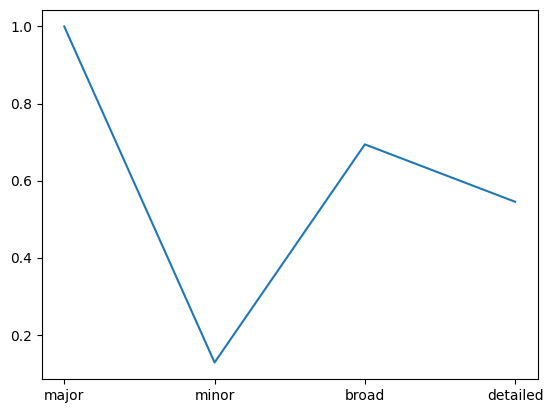

In [3]:
pct_major = round((len(df.loc[(df['occ_group'] == "major") & (df['women'] != "null")]) / 22), 3)
pct_minor = round((len(df.loc[(df['occ_group'] == "minor") & (df['women'] != "null")]) / 94), 3)
pct_broad = round((len(df.loc[(df['occ_group'] == "broad") & (df['women'] != "null")]) / 448), 3)
pct_detailed = round((len(df.loc[(df['occ_group'] == "detailed") & (df['women'] != "null")]) / 831), 3)

values = [pct_major, pct_minor, pct_broad, pct_detailed]
descriptions = ["major", "minor", "broad", "detailed"]

print(values)
plt.plot(descriptions, values)

## Deleting nulls, parsing floats

In [ ]:
df = df.loc[df['women'] != "null"] # delete nulls

# fix parsing as float and rounding
for col in ["women", "white", "african_american", "asian", "hispanic"]:
    df[col] = df[col].astype(float)
    df[col] = df[col].apply(lambda x: round(x, 3))

C:\Users\leond\AppData\Local\Temp\ipykernel_10096\3113283168.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df[col] = df[col].astype(float)
C:\Users\leond\AppData\Local\Temp\ipykernel_10096\3113283168.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df[col] = df[col].apply(lambda x: round(x, 3))


In [5]:
df = df.dropna()
df.head(3)

,occ_code,occ_group,occ_title,lenient_links,lenient_revs,lenient_lengths,women,white,african_american,asian,hispanic
0,11-0000,major,Management Occupations,"[[""Certified Financial Manager"", ""http://en.wi...","{""Certified Financial Manager"": [{""revid"": 581...","{""Certified Financial Manager"": 2611, ""Marketi...",0.409,0.822,0.086,0.065,0.111
2,11-1010,broad,Chief Executives,"[[""Chief executive officer"", ""http://en.wikipe...","{""Chief executive officer"": [{""revid"": 6437689...","{""Chief executive officer"": 17489}",0.291,0.857,0.059,0.068,0.074
3,11-1011,detailed,Chief Executives,"[[""Chief executive officer"", ""http://en.wikipe...","{""Chief executive officer"": [{""revid"": 6437689...","{""Chief executive officer"": 17489}",0.291,0.857,0.059,0.068,0.074


In [ ]:
df_major = df.loc[df['occ_group'] == "major"]
df_major.head(3)

,occ_code,occ_group,occ_title,lenient_links,lenient_revs,lenient_lengths,women,white,african_american,asian,hispanic
0,11-0000,major,Management Occupations,"[[""Certified Financial Manager"", ""http://en.wi...","{""Certified Financial Manager"": [{""revid"": 581...","{""Certified Financial Manager"": 2611, ""Marketi...",0.409,0.822,0.086,0.065,0.111
73,13-0000,major,Business and Financial Operations Occupations,"[[""Loan officer"", ""http://en.wikipedia.org/?cu...","{""Loan officer"": [{""revid"": 492957605, ""user"":...","{""Loan officer"": 10956, ""Financial adviser"": 2...",0.548,0.780,0.105,0.086,0.103
129,15-0000,major,Computer and Mathematical Occupations,"[[""Information scientist"", ""http://en.wikipedi...","{""Information scientist"": [{""revid"": 329917919...","{""Information scientist"": 2757, ""Software deve...",0.262,0.654,0.085,0.233,0.083


In [7]:
articles_per_detailed = amount_detailed(df, df_major)
unique_auths, page_lengths = avg_unique_auth_page_lengths(df_major)

if "art_per_detailed" not in df_major:
    df_major.insert(4, "art_per_detailed", articles_per_detailed)

if "avg_unique_auths" not in df_major:
    df_major.insert(6, "avg_unique_auths", unique_auths)
    
if "avg_page_lengths" not in df_major:
    df_major.insert(8, "avg_page_lengths", page_lengths)
    
df_major.head(3)

,occ_code,occ_group,occ_title,lenient_links,art_per_detailed,lenient_revs,avg_unique_auths,lenient_lengths,avg_page_lengths,women,white,african_american,asian,hispanic
0,11-0000,major,Management Occupations,"[[""Certified Financial Manager"", ""http://en.wi...",0.782609,"{""Certified Financial Manager"": [{""revid"": 581...",406.555556,"{""Certified Financial Manager"": 2611, ""Marketi...",16922.277778,0.409,0.822,0.086,0.065,0.111
73,13-0000,major,Business and Financial Operations Occupations,"[[""Loan officer"", ""http://en.wikipedia.org/?cu...",0.476190,"{""Loan officer"": [{""revid"": 492957605, ""user"":...",227.300000,"{""Loan officer"": 10956, ""Financial adviser"": 2...",11858.700000,0.548,0.780,0.105,0.086,0.103
129,15-0000,major,Computer and Mathematical Occupations,"[[""Information scientist"", ""http://en.wikipedi...",1.538462,"{""Information scientist"": [{""revid"": 329917919...",830.050000,"{""Information scientist"": 2757, ""Software deve...",16940.100000,0.262,0.654,0.085,0.233,0.083


In [8]:
def viz_two_axes(df, target_variable, second_metric):
    df_viz = df.sort_values(by = [second_metric])
    df_viz.plot(kind = "bar", x = "occ_code", y = [target_variable, second_metric], 
                secondary_y = [second_metric], rot = 0)
    plt.show()
    
def viz_scatterplot_correlation(df, target_variable, second_metric):
    articles = df[second_metric].tolist()
    target = df[target_variable].tolist()
    
    corr, _ = pearsonr(target, articles)
    print('Pearsons correlation: %.3f' % corr)
    
    plt.scatter(articles, target)
    plt.show()

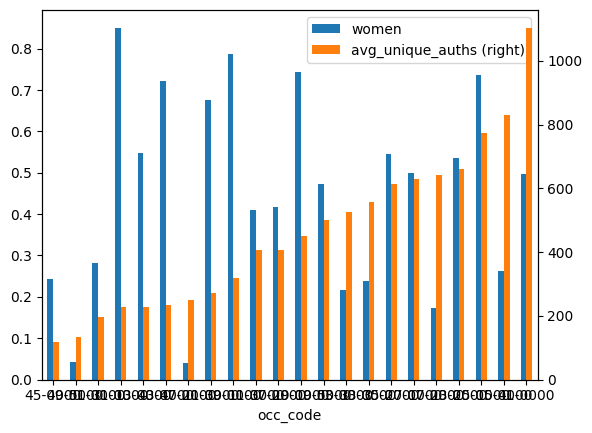

Pearsons correlation: 0.058


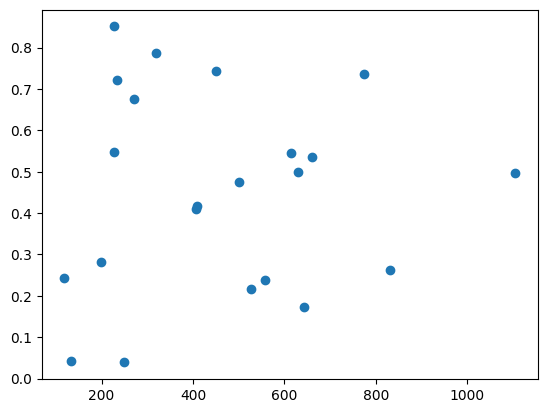

In [ ]:
viz_two_axes(df_major, "women", "avg_unique_auths")

viz_scatterplot_correlation(df_major, "women", "avg_unique_auths")
